## Feature Engineering and CV based Winners' Solutions

continued from eda_4_28

Trained@2015-06-28, validated@2015-12-28, mlogloss=1.28481

Private score: 0.0302054, public score: 0.0298683

To-do: 
- mean encoding of products grouped by combinations of: canal_entrada, segmento, cod_prov
- Time since change and lags for a few non-product features: 
    - segmento
    - ind_actividad_cliente
    - cod_prov
    - canal_entrada
    - indrel_1mes
    - tiprel_1mes


Features:
- eda_4_28
    - average of products for each (customer, product) pair
    - exponent weighted average of products each (customer, product) pair
    - time since presence of products, distance to the first 1
    - time to the last positive flank (01)
    - time to the last negative flank (10)
    - time to the last 1, to the nearest product purchase
    - time to the first 1, to the first product purchase
- before eda_4_25
    - customer info in the second month
    - products in the first month
    - combination of first and second month `ind_actividad_cliente`
    - combination of first and second month `tiprel_1mes`
    - combination of first month product by using binary number (`target_combine`)
    - encoding `target_combine` with 
        - mean number of new products
        - mean number of customers with new products
        - mean number of customers with each new products
    - Count patterns in the last `max_lag` months
    - Number of month to the last time the customer purchase each product
        - CV@2015-12-28: mlogloss=1.29349
        - Private score: 0.0302475, public score: 0.0299266
- eda_4_25
    - Use all available history data
        - E.g., for 2016-05-28 train data, use all previous months, for 2015-02-28, use 1 lag month. 
        - Need to create test set that use the same amount of previous months for each training data set. 
        - This is from [the second winner's solution](https://www.kaggle.com/c/santander-product-recommendation/discussion/26824), his bold part in paragraph 4.
    - Combine models trained on 2016-05-28 and 2015-06-28:
        - Private score: 0.0304583, public score: 0.0300839
        - This is to catch both seasonality and trend, presented in 2015-06-28 and 2016-05-28, respectively. 
        - This idea is mentioned by many winners, like [11-th winner](https://www.kaggle.com/c/santander-product-recommendation/discussion/26823) and [14-th winner](https://www.kaggle.com/c/santander-product-recommendation/discussion/26808)

- eda_4_27
    - put 2015-06-28 and 2016-05-28 in the same data set, with the same lag=5
        - Private score:0.0303096, public score: 0.0299867
        - Different as [11-th winner's discussion](https://www.kaggle.com/c/santander-product-recommendation/discussion/26823)
            > We tested this by adding 50% of May-16 data to our June model and sure enough, we went from 0.0301 to 0.0303. Then, we built separate models for Jun and May, but the ensemble didn’t work. We weren’t surprised because June data is better for seasonal products, and May data is better for trend products. And vice-versa, June data is bad for trend products and May data is bad for seasonal products. So, they sort of cancelled each other out.

        - But my score is always worse than theirs, maybe this is the reason why we have different observations

# Draft

In [1]:
from santander_helper import *

In [2]:
x_train_june15, y_train_june15 = create_train('2015-06-28', pattern_flag=True)
x_val_june15, y_val_june15 = create_train('2016-05-28', pattern_flag=True)

In [45]:
def calculate_weight(x_train, y_train):
    '''Calculate weights for xgboost'''
    x_train_ncodpers = pd.concat((x_train.loc[:, 'ncodpers'], y_train), axis=1, ignore_index=True)
    x_train_ncodpers.columns = ['ncodpers', 'n_target']
    x_train_ncodpers = pd.DataFrame(x_train_ncodpers.groupby('ncodpers')['n_target'].count())
    x_train_ncodpers['xgb_weight_1'] = 1.0/x_train_ncodpers['n_target']
    x_train_ncodpers['xgb_weight_2'] = np.exp(1.0/x_train_ncodpers['n_target']-1)
    
    xgb_weight = pd.DataFrame(x_train.loc[:, 'ncodpers'].copy()).join(x_train_ncodpers, on='ncodpers')
    xgb_weight.drop('n_target', axis=1, inplace=True)
    xgb_weight = xgb_weight.iloc[:, 1:].copy()
    
    return xgb_weight

In [47]:
xgb_weight = calculate_weight(x_train_june15, y_train_june15)

In [32]:
x_train_june15_ncodpers = pd.concat((x_train_june15.loc[:, 'ncodpers'], y_train_june15), axis=1, ignore_index=True)
x_train_june15_ncodpers.columns = ['ncodpers', 'n_target']
x_train_june15_ncodpers = pd.DataFrame(x_train_june15_ncodpers.groupby('ncodpers')['n_target'].count())
x_train_june15_ncodpers['xgb_weight_1'] = 1.0/x_train_june15_ncodpers['n_target']
x_train_june15_ncodpers['xgb_weight_2'] = np.exp(1.0/x_train_june15_ncodpers['n_target']-1)

xgb_weight = pd.DataFrame(x_train_june15.loc[:, 'ncodpers'].copy()).join(x_train_june15_ncodpers, on='ncodpers')
xgb_weight.drop('n_target', axis=1, inplace=True)
xgb_weight_1 = xgb_weight.iloc[:, 1].values
xgb_weight_2 = xgb_weight.iloc[:, 2].values

# Test

In [1]:
from santander_helper import *

### 2015-06-28, max_lag=5

In [6]:
x_train_june15, y_train_june15, weight_train_june15 = create_train('2015-06-28', pattern_flag=True)
x_val_june15, y_val_june15, weight_val_june15 = create_train('2016-05-28', pattern_flag=True)

x_test_june15 = create_test(pattern_flag=True)

param = {'objective': 'multi:softprob', 
         'eta': 0.05, 
         'max_depth': 4, 
         'silent': 1, 
         'num_class': len(target_cols),
         'eval_metric': 'mlogloss',
         'min_child_weight': 1,
         'subsample': 0.7,
         'colsample_bytree': 0.7,
         'seed': 0}
num_rounds = 250
eval_history = {}

In [7]:
weight_idx = 0
for weight_idx in [0, 1]:
    eval_history[weight_idx] = {}
    dtrain_june15 = xgb.DMatrix(x_train_june15, y_train_june15, weight=weight_train_june15.values[:, weight_idx])
    dval_june15 = xgb.DMatrix(x_val_june15, y_val_june15, weight=weight_val_june15.values[:, weight_idx])
    model_june15 = xgb.train(param, dtrain_june15, num_rounds, 
                             evals=[(dtrain_june15, 'train'), (dval_june15, 'dval')], 
                             verbose_eval=True, evals_result=eval_history[weight_idx])

[0]	train-mlogloss:2.67673	dval-mlogloss:2.69823
[1]	train-mlogloss:2.49074	dval-mlogloss:2.52495
[2]	train-mlogloss:2.34356	dval-mlogloss:2.39247
[3]	train-mlogloss:2.22236	dval-mlogloss:2.28039
[4]	train-mlogloss:2.11922	dval-mlogloss:2.18952
[5]	train-mlogloss:2.02934	dval-mlogloss:2.10505
[6]	train-mlogloss:1.94954	dval-mlogloss:2.03087
[7]	train-mlogloss:1.87774	dval-mlogloss:1.96457
[8]	train-mlogloss:1.81368	dval-mlogloss:1.90596
[9]	train-mlogloss:1.75547	dval-mlogloss:1.85178
[10]	train-mlogloss:1.70167	dval-mlogloss:1.80365
[11]	train-mlogloss:1.65222	dval-mlogloss:1.75794
[12]	train-mlogloss:1.60629	dval-mlogloss:1.71694
[13]	train-mlogloss:1.56353	dval-mlogloss:1.67702
[14]	train-mlogloss:1.52385	dval-mlogloss:1.6399
[15]	train-mlogloss:1.48672	dval-mlogloss:1.60566
[16]	train-mlogloss:1.45192	dval-mlogloss:1.57349
[17]	train-mlogloss:1.41942	dval-mlogloss:1.54328
[18]	train-mlogloss:1.38885	dval-mlogloss:1.51608
[19]	train-mlogloss:1.36057	dval-mlogloss:1.49131
[20]	train-

[160]	train-mlogloss:0.719187	dval-mlogloss:0.925367
[161]	train-mlogloss:0.718665	dval-mlogloss:0.925162
[162]	train-mlogloss:0.718083	dval-mlogloss:0.924798
[163]	train-mlogloss:0.717473	dval-mlogloss:0.924462
[164]	train-mlogloss:0.716901	dval-mlogloss:0.924398
[165]	train-mlogloss:0.716384	dval-mlogloss:0.924188
[166]	train-mlogloss:0.715847	dval-mlogloss:0.92389
[167]	train-mlogloss:0.71534	dval-mlogloss:0.924009
[168]	train-mlogloss:0.714828	dval-mlogloss:0.924161
[169]	train-mlogloss:0.714316	dval-mlogloss:0.923908
[170]	train-mlogloss:0.713778	dval-mlogloss:0.923749
[171]	train-mlogloss:0.713199	dval-mlogloss:0.923233
[172]	train-mlogloss:0.712718	dval-mlogloss:0.923015
[173]	train-mlogloss:0.712263	dval-mlogloss:0.922748
[174]	train-mlogloss:0.711743	dval-mlogloss:0.92248
[175]	train-mlogloss:0.71121	dval-mlogloss:0.922251
[176]	train-mlogloss:0.710711	dval-mlogloss:0.922088
[177]	train-mlogloss:0.710194	dval-mlogloss:0.921656
[178]	train-mlogloss:0.70972	dval-mlogloss:0.92189

[70]	train-mlogloss:0.890025	dval-mlogloss:1.06525
[71]	train-mlogloss:0.88677	dval-mlogloss:1.06267
[72]	train-mlogloss:0.883635	dval-mlogloss:1.05981
[73]	train-mlogloss:0.880652	dval-mlogloss:1.057
[74]	train-mlogloss:0.877791	dval-mlogloss:1.05441
[75]	train-mlogloss:0.874995	dval-mlogloss:1.05221
[76]	train-mlogloss:0.872339	dval-mlogloss:1.04986
[77]	train-mlogloss:0.869764	dval-mlogloss:1.04756
[78]	train-mlogloss:0.867119	dval-mlogloss:1.04529
[79]	train-mlogloss:0.864611	dval-mlogloss:1.04288
[80]	train-mlogloss:0.862183	dval-mlogloss:1.04095
[81]	train-mlogloss:0.859881	dval-mlogloss:1.03914
[82]	train-mlogloss:0.85764	dval-mlogloss:1.03727
[83]	train-mlogloss:0.855405	dval-mlogloss:1.03571
[84]	train-mlogloss:0.853225	dval-mlogloss:1.03367
[85]	train-mlogloss:0.851165	dval-mlogloss:1.03153
[86]	train-mlogloss:0.849066	dval-mlogloss:1.02972
[87]	train-mlogloss:0.84703	dval-mlogloss:1.02798
[88]	train-mlogloss:0.84512	dval-mlogloss:1.02657
[89]	train-mlogloss:0.843238	dval-mlo

[227]	train-mlogloss:0.743153	dval-mlogloss:0.97241
[228]	train-mlogloss:0.742824	dval-mlogloss:0.972352
[229]	train-mlogloss:0.74246	dval-mlogloss:0.972674
[230]	train-mlogloss:0.742158	dval-mlogloss:0.972747
[231]	train-mlogloss:0.741753	dval-mlogloss:0.972801
[232]	train-mlogloss:0.741401	dval-mlogloss:0.972805
[233]	train-mlogloss:0.741047	dval-mlogloss:0.972658
[234]	train-mlogloss:0.740654	dval-mlogloss:0.97278
[235]	train-mlogloss:0.740336	dval-mlogloss:0.972577
[236]	train-mlogloss:0.739974	dval-mlogloss:0.972511
[237]	train-mlogloss:0.739518	dval-mlogloss:0.972494
[238]	train-mlogloss:0.739154	dval-mlogloss:0.972698
[239]	train-mlogloss:0.738764	dval-mlogloss:0.972655
[240]	train-mlogloss:0.738427	dval-mlogloss:0.972525
[241]	train-mlogloss:0.738087	dval-mlogloss:0.972512
[242]	train-mlogloss:0.737774	dval-mlogloss:0.972524
[243]	train-mlogloss:0.737371	dval-mlogloss:0.972651
[244]	train-mlogloss:0.73697	dval-mlogloss:0.972443
[245]	train-mlogloss:0.736606	dval-mlogloss:0.9726

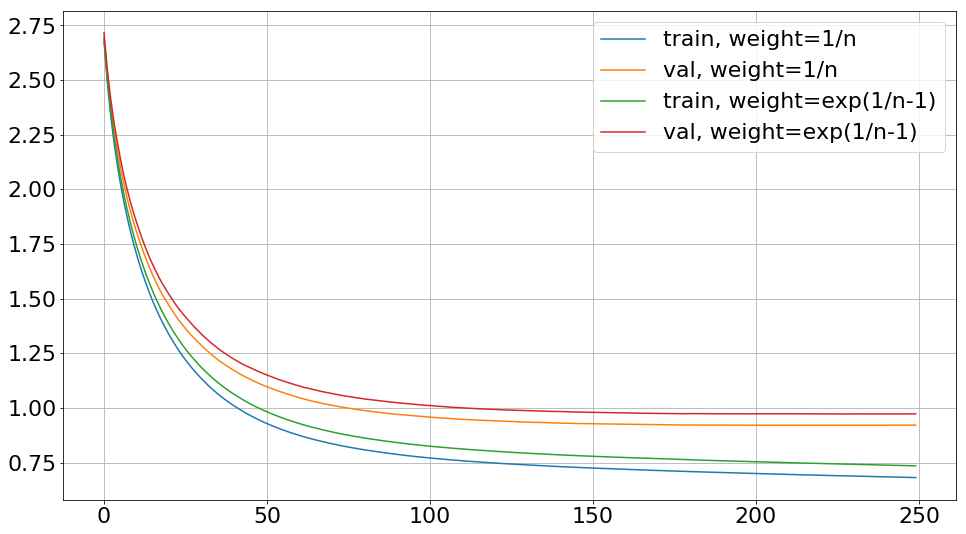

In [16]:
plt.figure(figsize=(16, 9))
plt.rcParams.update({'font.size': 22})
plt.plot(eval_history[0]['train']['mlogloss'], label='train, weight=1/n')
plt.plot(eval_history[0]['dval']['mlogloss'], label='val, weight=1/n')
plt.plot(eval_history[1]['train']['mlogloss'], label='train, weight=exp(1/n-1)')
plt.plot(eval_history[1]['dval']['mlogloss'], label='val, weight=exp(1/n-1)')
plt.legend()
plt.grid()

In [ ]:
preds_june15 = model_june15.predict(xgb.DMatrix(x_test_june15))

df_preds_june15 = pd.DataFrame(preds_june15, index=x_test_june15.index, columns=target_cols)
# Remove already bought products 
df_preds_june15[x_test_june15[target_cols]==1] = 0 
preds_june15 = df_preds_june15.values
preds_june15 = np.argsort(preds_june15, axis=1)
preds_june15 = np.fliplr(preds_june15)[:, :7]

test_id = x_test_june15.loc[:, 'ncodpers'].values
final_preds_june15 = [' '.join([target_cols[k] for k in pred]) for pred in preds_june15]

out_df_june15 = pd.DataFrame({'ncodpers': test_id, 'added_products': final_preds_june15})
out_df_june15.to_csv('eda_4_28_june15_it100.csv.gz', compression='gzip', index=False)

### 2016-05-28, max_lag=16

In [3]:
x_train_may16, y_train_may16 = create_train('2015-05-28', pattern_flag=True, max_lag=16)

x_test_may16 = create_test(pattern_flag=True)

param = {'objective': 'multi:softprob', 
         'eta': 0.05, 
         'max_depth': 8, 
         'silent': 1, 
         'num_class': len(target_cols),
         'eval_metric': 'mlogloss',
         'min_child_weight': 1,
         'subsample': 0.7,
         'colsample_bytree': 0.7,
         'seed': 0}
num_rounds = 60

dtrain_may16 = xgb.DMatrix(x_train_may16.values, y_train_may16.values)
model_may16 = xgb.train(param, dtrain_may16, num_rounds, evals=[(dtrain_may16, 'train')], verbose_eval=True)

preds_may16 = model_may16.predict(xgb.DMatrix(x_test_may16.values))

df_preds_may16 = pd.DataFrame(preds_may16, index=x_test_may16.index, columns=target_cols)
# Remove already bought products 
df_preds_may16[x_test_may16[target_cols]==1] = 0 
preds_may16 = df_preds_may16.values
preds_may16 = np.argsort(preds_may16, axis=1)
preds_may16 = np.fliplr(preds_may16)[:, :7]

test_id = x_test_may16.loc[:, 'ncodpers'].values
final_preds_may16 = [' '.join([target_cols[k] for k in pred]) for pred in preds_may16]

out_df_may16 = pd.DataFrame({'ncodpers': test_id, 'added_products': final_preds_may16})
out_df_may16.to_csv('eda_4_28_may16.csv.gz', compression='gzip', index=False)

[0]	train-mlogloss:2.64321
[1]	train-mlogloss:2.42916
[2]	train-mlogloss:2.26143
[3]	train-mlogloss:2.12057
[4]	train-mlogloss:2.00099
[5]	train-mlogloss:1.89603
[6]	train-mlogloss:1.80356
[7]	train-mlogloss:1.72067
[8]	train-mlogloss:1.64465
[9]	train-mlogloss:1.57663
[10]	train-mlogloss:1.51355
[11]	train-mlogloss:1.45557
[12]	train-mlogloss:1.40214
[13]	train-mlogloss:1.35231
[14]	train-mlogloss:1.30587
[15]	train-mlogloss:1.26249
[16]	train-mlogloss:1.222
[17]	train-mlogloss:1.18383
[18]	train-mlogloss:1.14811
[19]	train-mlogloss:1.11448
[20]	train-mlogloss:1.08268
[21]	train-mlogloss:1.0525
[22]	train-mlogloss:1.02404
[23]	train-mlogloss:0.997108
[24]	train-mlogloss:0.971606
[25]	train-mlogloss:0.947348
[26]	train-mlogloss:0.924398
[27]	train-mlogloss:0.902768
[28]	train-mlogloss:0.881792
[29]	train-mlogloss:0.861978
[30]	train-mlogloss:0.842969
[31]	train-mlogloss:0.824979
[32]	train-mlogloss:0.80799
[33]	train-mlogloss:0.791558
[34]	train-mlogloss:0.776193
[35]	train-mlogloss:0.

### Combine two models

In [4]:
preds_june15 = model_june15.predict(xgb.DMatrix(x_test_june15.values))
preds_may16 = model_may16.predict(xgb.DMatrix(x_test_may16.values))

preds1 = np.sqrt(preds_june15*preds_may16)
preds2 = 0.5*preds_june15 + 0.5*preds_may16

# Geometry mean
df_preds1 = pd.DataFrame(preds1, index=x_test_may16.index, columns=target_cols)
# Remove already bought products 
df_preds1[x_test_may16[target_cols]==1] = 0 
preds1 = df_preds1.values
preds1 = np.argsort(preds1, axis=1)
preds1 = np.fliplr(preds1)[:, :7]

test_id = x_test_may16.loc[:, 'ncodpers'].values
final_preds1 = [' '.join([target_cols[k] for k in pred]) for pred in preds1]

out_df1 = pd.DataFrame({'ncodpers': test_id, 'added_products': final_preds1})
out_df1.to_csv('eda_4_28_gm.csv.gz', compression='gzip', index=False)

# Algorithmic mean
df_preds2 = pd.DataFrame(preds2, index=x_test_may16.index, columns=target_cols)
# Remove already bought products 
df_preds2[x_test_may16[target_cols]==1] = 0 
preds2 = df_preds2.values
preds2 = np.argsort(preds2, axis=1)
preds2 = np.fliplr(preds2)[:, :7]

test_id = x_test_may16.loc[:, 'ncodpers'].values
final_preds2 = [' '.join([target_cols[k] for k in pred]) for pred in preds2]

out_df2 = pd.DataFrame({'ncodpers': test_id, 'added_products': final_preds2})
out_df2.to_csv('eda_4_28_am.csv.gz', compression='gzip', index=False)
